In [58]:
import pandas as pd
import numpy as np
from mab2rec.utils import print_interaction_stats
import seaborn as sns
import matplotlib.pyplot as plt
from mab2rec import BanditRecommender, LearningPolicy, NeighborhoodPolicy
from jurity.recommenders import BinaryRecoMetrics, RankingRecoMetrics
from mab2rec.pipeline import benchmark
sns.set_style("whitegrid")
import warnings
from mab2rec.visualization import plot_metrics_at_k
from mab2rec.visualization import plot_intra_diversity_at_k
from crowdkit.aggregation import Wawa
from tqdm.auto import tqdm

def get_num_people_by_age_category(df):
    df["age_group"] = pd.cut(
        x=df["age"], bins=np.arange(90, step=10), labels=np.arange(90, step=10)[:-1]
    )
    return df


full_data = pd.read_csv(
    "./data/ml-100k/u.data",
    names=["user_id", "item_id", "rating"],
    usecols=(0, 1, 2),
    sep="\t",
)
user_features = pd.read_csv(
    "./data/ml-100k/u.user",
    names=["user_id", "age", "genre", "occupation", "other"],
    sep="|",
)
user_features.drop(["genre", "other"], axis=1, inplace=True)
user_features = pd.get_dummies(user_features, columns=["occupation"], drop_first=True)
user_features = get_num_people_by_age_category(user_features)
user_features.drop(["age"], axis=1, inplace=True)
user_features = pd.get_dummies(user_features, columns=["age_group"], drop_first=True)
names = ["item_id", "name", "date", "other", "url"] + [f"genre_{i}" for i in range(19)]
item_features = pd.read_csv(
    "./data/ml-100k/u.item", names=names, sep="|", encoding="latin-1"
)
item_features.drop(["other", "name", "date", "url"], axis=1, inplace=True)
item_features.to_csv("./data/ml-100k/item_features.csv", index=False)
user_features.to_csv("./data/ml-100k/user_features.csv", index=False)
test_data = pd.read_csv(
    "./data/ml-100k/ua.test",
    delimiter="\t",
    header=None,
    names=["user_id", "item_id", "rating"],
    usecols=(0, 1, 2),
)
movies_to_keep = (
    pd.DataFrame(full_data["item_id"].value_counts().reset_index())
    .loc[
        pd.DataFrame(full_data["item_id"].value_counts()).reset_index()["count"]
        >= 20
    ]["item_id"]
)
full_data = full_data.loc[full_data['item_id'].isin(movies_to_keep)]
test_data = test_data.loc[test_data['item_id'].isin(movies_to_keep)]
train_data = (
    pd.merge(
        full_data,
        test_data,
        on=["user_id", "item_id", "rating"],
        how="outer",
        indicator=True,
    )
    .query("_merge != 'both'")
    .drop("_merge", axis=1)
    .reset_index(drop=True)
)
train_data["rating"] = train_data["rating"] > 4
test_data["rating"] = test_data["rating"] > 4
train_data.columns = ["user_id", "item_id", "response"]
test_data.columns = ["user_id", "item_id", "response"]
test_data.to_csv("./data/ml-100k/test_data.csv", index=False)
train_data.to_csv("./data/ml-100k/train_data.csv", index=False)
dir_data = "./data/ml-100k/"

train_data = dir_data + "train_data.csv"
test_data = dir_data + "test_data.csv"
user_data = "./../mab2rec/data/" + "features_user.csv"
user_df = pd.read_csv(user_data)
item_data = dir_data + "item_features.csv"

train_df = pd.read_csv(train_data)
train_df.head()

,user_id,item_id,response
0,1,1,True
1,1,2,False
2,1,3,False
3,1,4,False
4,1,5,False


In [59]:
test_df = pd.read_csv(dir_data+"test_data.csv")

print("=== TRAIN ===")
print_interaction_stats(train_df)

print("=== TEST ===")
print_interaction_stats(test_df)

=== TRAIN ===
Number of rows: 85,887
Number of users: 943
Number of items: 939
Mean response rate: 0.2165

=== TEST ===
Number of rows: 9,081
Number of users: 943
Number of items: 891
Mean response rate: 0.2308



In [60]:
item_df = pd.read_csv(dir_data+"item_features.csv")
item_df.head()

,item_id,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,genre_18
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [61]:
def get_train_recommenders(train_data,test_data, user_data):
    # Set of recommenders
    recommenders = {
        "Random": BanditRecommender(learning_policy=LearningPolicy.Random()),
        "LinGreedy": BanditRecommender(
            learning_policy=LearningPolicy.LinGreedy(epsilon=0.1)
        ),
        "LinUCB": BanditRecommender(
            learning_policy=LearningPolicy.LinUCB(alpha=1, l2_lambda=1)
        ),
        "TS": BanditRecommender(learning_policy=LearningPolicy.ThompsonSampling()),
        "LinTS": BanditRecommender(learning_policy=LearningPolicy.LinTS()),
        "ClustersTS(L=5)": BanditRecommender(
            learning_policy=LearningPolicy.ThompsonSampling(),
            neighborhood_policy=NeighborhoodPolicy.Clusters(n_clusters=5),
        ),
        "ClustersTS(L=10)": BanditRecommender(
            learning_policy=LearningPolicy.ThompsonSampling(),
            neighborhood_policy=NeighborhoodPolicy.Clusters(n_clusters=10),
        ),
        "ClustersTS(L=20)": BanditRecommender(
            learning_policy=LearningPolicy.ThompsonSampling(),
            neighborhood_policy=NeighborhoodPolicy.Clusters(n_clusters=20),
        ),
        "ClustersTS(L=30)": BanditRecommender(
            learning_policy=LearningPolicy.ThompsonSampling(),
            neighborhood_policy=NeighborhoodPolicy.Clusters(n_clusters=30),
        ),
        "ClustersTS(L=40)": BanditRecommender(
            learning_policy=LearningPolicy.ThompsonSampling(),
            neighborhood_policy=NeighborhoodPolicy.Clusters(n_clusters=40),
        ),
        "LSHNearest": BanditRecommender(
            learning_policy=LearningPolicy.EpsilonGreedy(epsilon=0.1),
            neighborhood_policy=NeighborhoodPolicy.LSHNearest(5, 3),
        ),
    }
    metric_params = {
    "click_column": "score",
    "user_id_column": "user_id",
    "item_id_column": "item_id",
}

    # Evaluate peformance at different k-recommendations
    top_k_list = [3, 5, 10]

    # List of metrics to benchmark
    metrics = []
    for k in top_k_list:
        metrics.append(BinaryRecoMetrics.AUC(**metric_params, k=k))
        metrics.append(BinaryRecoMetrics.CTR(**metric_params, k=k))
        metrics.append(RankingRecoMetrics.Precision(**metric_params, k=k))
        metrics.append(RankingRecoMetrics.Recall(**metric_params, k=k))
        metrics.append(RankingRecoMetrics.NDCG(**metric_params, k=k))
        metrics.append(RankingRecoMetrics.MAP(**metric_params, k=k))
    reco_to_results, reco_to_metrics = benchmark(
        recommenders,
        metrics=metrics,
        train_data=train_data,
        test_data=test_data,
        user_features=user_data,
    )
    return recommenders, metrics, reco_to_results, reco_to_metrics

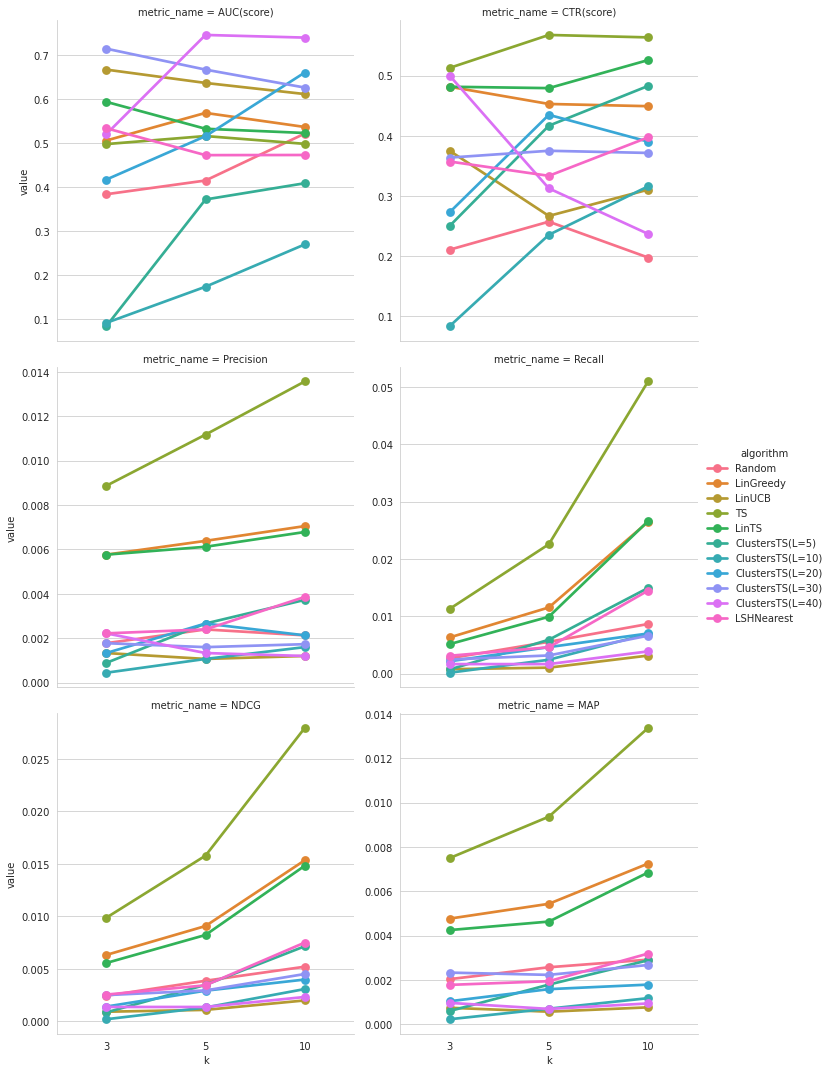

In [62]:
recommenders, metrics, reco_to_results, reco_to_metrics = get_train_recommenders(train_data, test_data, user_data)
# Plot each metric across all algorithms at different k
plot_metrics_at_k(reco_to_metrics, col_wrap=2)

## Movielens twothird simulation

In [63]:
user_df2 = user_df.drop("user_id", axis=1)
item_df.index = item_df["item_id"]
item_df

,item_id,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,genre_18
item_id,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,1678,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1679,1679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1680,1680,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [64]:
by_genre_df_train = {"user_id": [], "item_id": [], "reward": []}
item_df.index = item_df["item_id"]
for i, row in train_df.iterrows():
    item_genre = np.nonzero(item_df.loc[row[1]])[0][1:] - 1
    for genre in item_genre:
        by_genre_df_train["user_id"].append(row[0])
        by_genre_df_train["item_id"].append(genre)
        by_genre_df_train["reward"].append(row[2])
by_genre_df_train = pd.DataFrame(by_genre_df_train)
by_genre_df_train = (
    by_genre_df_train.groupby(["user_id", "item_id"]).count().reset_index()
)
by_genre_df_train["response"] = by_genre_df_train["reward"] > 5

In [65]:
by_genre_df_test = {"user_id": [], "item_id": [], "reward": []}
item_df.index = item_df["item_id"]
for i, row in test_df.iterrows():
    item_genre = np.nonzero(item_df.loc[row[1]])[0][1:] - 1
    for genre in item_genre:
        by_genre_df_test["user_id"].append(row[0])
        by_genre_df_test["item_id"].append(genre)
        by_genre_df_test["reward"].append(row[2])
by_genre_df_test = pd.DataFrame(by_genre_df_test)
by_genre_df_test = by_genre_df_test.groupby(["user_id", "item_id"]).count().reset_index()
by_genre_df_test["response"] = by_genre_df_test["reward"] > 5

In [66]:
print("=== TRAIN ===")
print_interaction_stats(by_genre_df_train)

print("=== TEST ===")
print_interaction_stats(by_genre_df_test)

=== TRAIN ===
Number of rows: 13,552
Number of users: 943
Number of items: 18
Mean response rate: 0.5269

=== TEST ===
Number of rows: 8,883
Number of users: 943
Number of items: 18
Mean response rate: 0.0399



In [67]:
by_genre_df_train.to_csv(dir_data + "train_by_genre.csv", index=False)
by_genre_df_test.to_csv(dir_data + "test_by_genre.csv", index=False)
recommenders, metrics, reco_to_results, reco_to_metrics = get_train_recommenders(
    dir_data + "train_by_genre.csv", dir_data + "test_by_genre.csv", user_data
    )

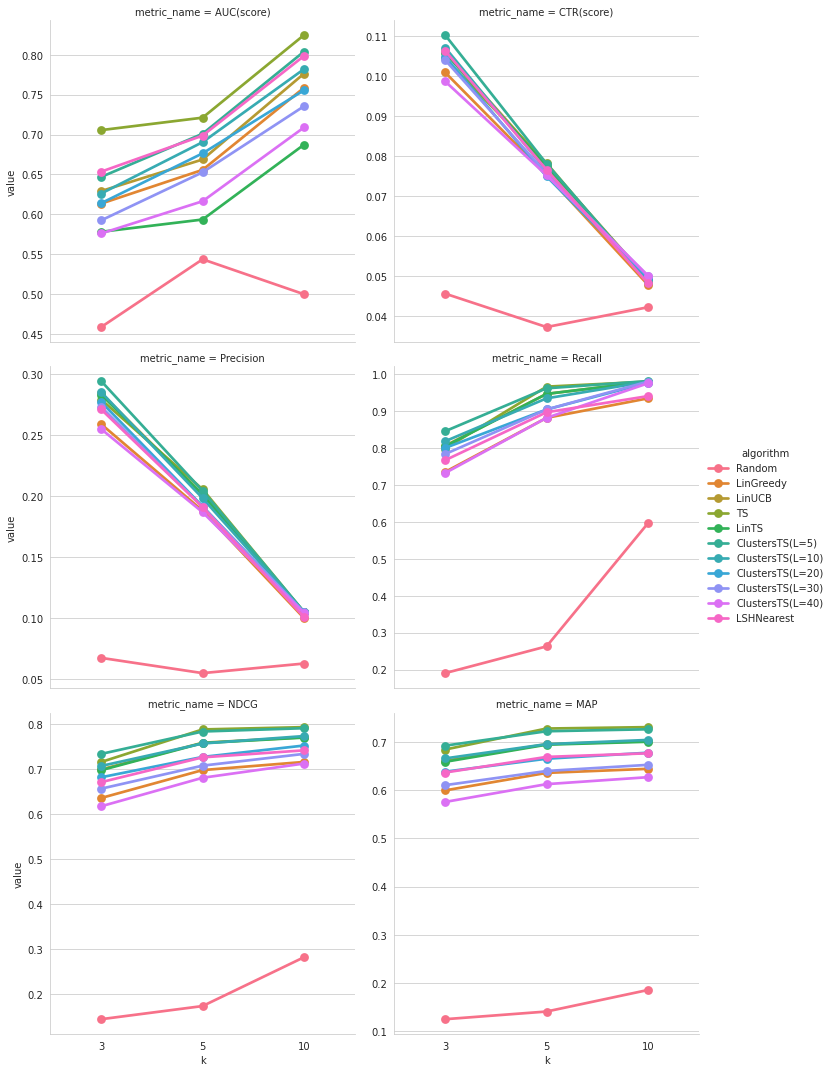

In [68]:
plot_metrics_at_k(reco_to_metrics, col_wrap=2)

In [69]:
user_df = pd.read_csv(user_data)
item_df = pd.read_csv(item_data)
user_df2 = user_df.drop("user_id", axis=1)

In [72]:
warnings.filterwarnings("ignore")
np.random.seed(123)
budgets = np.arange(
    100,
    2001,
    step=200,
)
results_2 = {
    "seed": [],
    "recommender": [],
    "annotated": [],
    "skipped": [],
    "budget": [],
}
for seed in tqdm(range(20), leave=True):
    budget = budgets[-1]
    for name, rec in recommenders.items():
        # print("===============", name, "===============")
        users = test_df["user_id"].unique()
        genras = by_genre_df_test.item_id.unique()
        recommended_genres = []
        pools = {key: [] for key in genras}
        for key in genras:
            pools[key].append(
                    item_df["item_id"][np.nonzero(item_df[f"genre_{key}"])[0]].values
                )
            pools[key] = pools[key][0]
        skipping = 0
        quality_threshold = np.zeros(test_df.item_id.max() + 1)
        binary_votes = np.zeros((quality_threshold.shape[0], 2))
        stop_condition = True
        budget_real = 0

        while stop_condition:
            user = np.random.choice(users)
            if rec.mab.is_contextual:
                category = rec.predict(user_df2.iloc[user - 1])
            else:
                category = rec.predict()
            recommended_genres.append(category)
            tmp_user = test_df.loc[test_df["user_id"] == user]
            movies = pools[category]
            if any(tmp_user["item_id"].isin(movies)):
                tmp_user = tmp_user.loc[tmp_user["item_id"].isin(movies)]
                available = False
                skip = False
                while not available:
                    item = np.random.choice(tmp_user["item_id"])
                    if all(quality_threshold[tmp_user["item_id"].values]):
                        available = True
                        skip = True
                    if quality_threshold[item] == 0:
                        available = True
                if not skip:
                    response = tmp_user.loc[tmp_user["item_id"] == item]["response"]
                    binary_votes[item, int(response)] += 1
                    quality_threshold[item] = (
                            np.max(binary_votes[item] / binary_votes[item].sum())
                            >= 2 / 3
                        ) and (binary_votes[item].sum() >= 2)
                    budget_real += 1
                if budget_real in budgets:
                    stop_condition = False if budget_real == budget else True
                    results_2["seed"].append(seed)
                    results_2["recommender"].append(name)
                    results_2["annotated"].append(quality_threshold.sum())
                    results_2["budget"].append(budget_real)
                    results_2["skipped"].append(skipping)
            else:
                skipping += 1
                budget_real += 1
                if budget_real in budgets:
                    stop_condition = False if budget_real == budget else True
                    results_2["seed"].append(seed)
                    results_2["recommender"].append(name)
                    results_2["annotated"].append(quality_threshold.sum())
                    results_2["budget"].append(budget_real)
                    results_2["skipped"].append(skipping)
                continue
results_2 = pd.DataFrame(results_2)
results_2.to_csv("./outputs/results_movielens-100k_low_budget.csv")
results_2

  0%|          | 0/20 [00:00<?, ?it/s]

,seed,recommender,annotated,skipped,budget
0,0,Random,6.0,43,100
1,0,Random,25.0,151,300
2,0,Random,52.0,250,500
3,0,Random,81.0,351,700
4,0,Random,109.0,476,900
...,...,...,...,...,...
18708,19,LSHNearest,432.0,588,1700
18709,19,LSHNearest,432.0,588,1700
18710,19,LSHNearest,432.0,588,1700
18711,19,LSHNearest,432.0,588,1700


------------------------------
                               mean  count       std     ci95_hi     ci95_lo
recommender      budget                                                     
ClustersTS(L=10) 100      11.000000     20  2.675424   12.172556    9.827444
                 300      65.521739     23  5.426112   67.739327   63.304151
                 500     141.720000     25  6.579767  144.299269  139.140731
                 700     230.257143     35  6.740321  232.490214  228.024071
                 900     324.169492     59  5.109668  325.473327  322.865656
...                             ...    ...       ...         ...         ...
TS               1100    357.000000    950  0.000000  357.000000  357.000000
                 1300    357.000000    995  0.000000  357.000000  357.000000
                 1500    357.000000   1064  0.000000  357.000000  357.000000
                 1700    357.000000   1220  0.000000  357.000000  357.000000
                 1900    357.000000     20  0

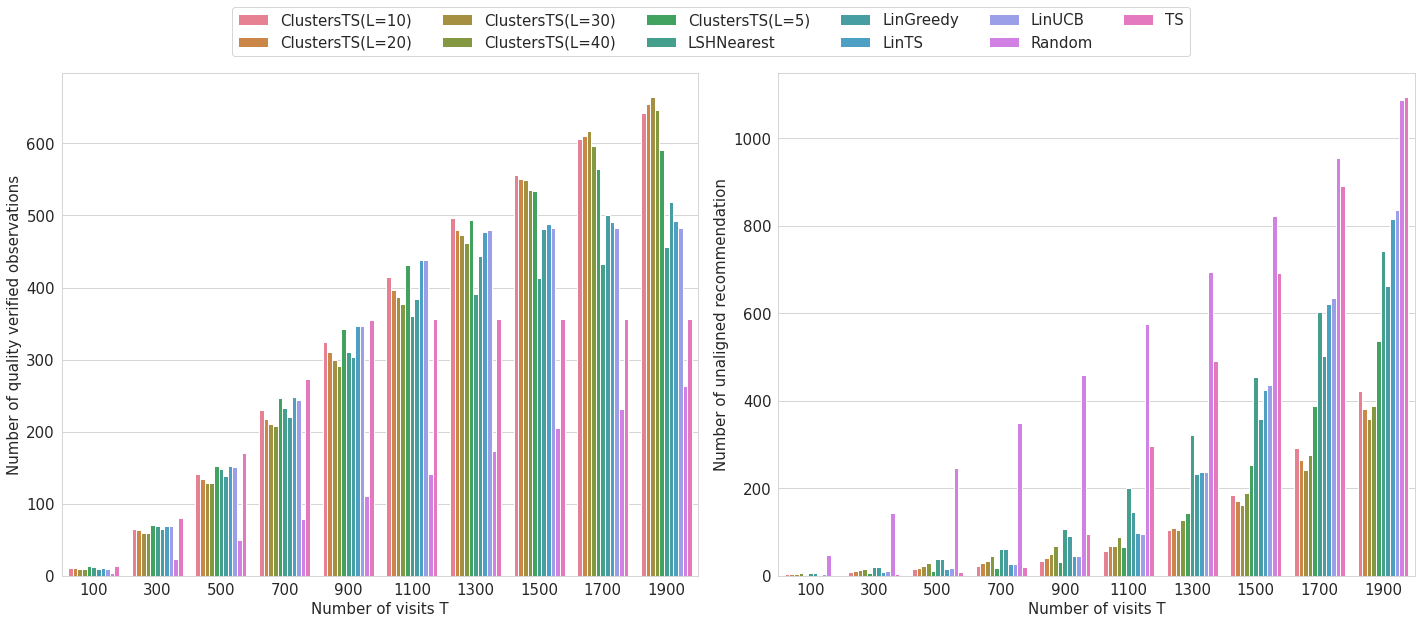

In [84]:
plt.rcParams.update({"font.size": 15})
results_2 = pd.DataFrame(results_2)
results_2["ratio"] = results_2["annotated"] / results_2["skipped"]
stats_2 = results_2.groupby(["recommender", "budget"])["annotated"].agg(
    ["mean", "count", "std"]
)
print("-" * 30)

ci95_hi = []
ci95_lo = []

for i in stats_2.index:
    m, c, s = stats_2.loc[i]
    ci95_hi.append(m + 1.96 * s / np.sqrt(c))
    ci95_lo.append(m - 1.96 * s / np.sqrt(c))
stats_2["ci95_hi"] = ci95_hi
stats_2["ci95_lo"] = ci95_lo
print(stats_2)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(data=stats_2, x="budget", y="mean", hue="recommender", ax=axs[0])
handles, labels = axs[0].get_legend_handles_labels()
axs[0].get_legend().remove()
axs[0].set_ylabel("Number of quality verified observations")
stats_2 = results_2.groupby(["recommender", "budget"])["skipped"].agg(
    ["mean", "count", "std"]
)
print("-" * 30)

ci95_hi = []
ci95_lo = []

for i in stats_2.index:
    m, c, s = stats_2.loc[i]
    ci95_hi.append(m + 1.96 * s / np.sqrt(c))
    ci95_lo.append(m - 1.96 * s / np.sqrt(c))
stats_2["ci95_hi"] = ci95_hi
stats_2["ci95_lo"] = ci95_lo
sns.barplot(data=stats_2, x="budget", y="mean", hue="recommender", ax=axs[1],legend=None)
axs[1].set_ylabel("Number of unaligned recommendation")
fig.legend(handles, labels, ncol=6, loc="upper center", bbox_to_anchor=(.5, 1.1))
axs[0].set_xlabel("Number of visits T")
axs[1].set_xlabel("Number of visits T")
plt.tight_layout()
plt.savefig("./outputs/movielens-100k-low-buget-perfs.pdf", bbox_inches="tight")

warnings.filterwarnings("ignore")
np.random.seed(123)
budgets = np.arange(
    100,
    2001,
    step=200,
)
results_3 = {
    "seed": [],
    "recommender": [],
    "annotated": [],
    "skipped": [],
    "budget": [],
}
items =test_df["item_id"].unique()
skills = {"seed": [], "budget": [], "recommender": [], "t": [], "skills": []}
for seed in tqdm(range(20), leave=True):
    budget = budgets[-1]
    for name, rec in recommenders.items():
        users = test_df["user_id"].unique()
        W = np.ones(len(users))
        genras = by_genre_df_test.item_id.unique()
        recommended_genres = []
        pools = {key: [] for key in genras}
        skipping = 0
        for key in genras:
            pools[key].append(
                item_df["item_id"][np.nonzero(item_df[f"genre_{key}"])[0]].values
            )
            pools[key] = pools[key][0]
        rec_agg = {"task": [], "worker": [], "label": []}
        weight_by_item = pd.DataFrame({"item_id": items, "value": 0}).set_index("item_id")
        quality_threshold = (weight_by_item["value"] > 1)
        stop_condition = True
        budget_real = 0
        while stop_condition:
            weight_by_item = pd.DataFrame({"item_id": items, "value": 0}).set_index("item_id")
            user = np.random.choice(users)
            if rec.mab.is_contextual:
                category = rec.predict(user_df2.iloc[user - 1])
            else:
                category = rec.predict()
            recommended_genres.append(category)
            tmp_user = test_df.loc[test_df["user_id"] == user]
            movies = pools[category]
            if any(tmp_user["item_id"].isin(movies)):
                tmp_user = tmp_user.loc[tmp_user["item_id"].isin(movies)]
                available = False
                skip = False
                num = 0
                if all(quality_threshold.loc[tmp_user["item_id"].values]):
                    available = True
                    skip = True
                while not available:
                    item = (
                        weight_by_item.loc[tmp_user["item_id"].values]
                        .sort_values(by="value")
                        .index[::-1]
                    )[num]
                    if quality_threshold.loc[item] == 0:
                        available = True
                    else:
                        num += 1
                if not skip:
                    response = tmp_user.loc[tmp_user["item_id"] == item]["response"]
                    rec_agg["task"].append(item)
                    rec_agg["worker"].append(user)
                    rec_agg["label"].append(int(response))
                    ww = Wawa().fit(pd.DataFrame(rec_agg))
                    skills_ = ww.skills_
                    for _, (task, user, _) in pd.DataFrame(rec_agg).iterrows():
                        weight_by_item.loc[task] += skills_.loc[user]
                    quality_threshold = (weight_by_item["value"] > 3)
                    budget_real += 1
                if budget_real in budgets:
                    stop_condition = False if budget_real == budget else True
                    results_3["seed"].append(seed)
                    results_3["recommender"].append(name)
                    results_3["annotated"].append(quality_threshold.sum())
                    results_3["budget"].append(budget_real)
                    results_3["skipped"].append(skipping)
                    skills["seed"].append(seed)
                    skills["recommender"].append(name)
                    skills["t"].append(budget_real)
                    skills["skills"].append(skills_)
            else:
                skipping += 1
                budget_real += 1
                if budget_real in budgets:
                    stop_condition = False if budget_real == budget else True
                    results_3["seed"].append(seed)
                    results_3["recommender"].append(name)
                    results_3["annotated"].append(quality_threshold.sum())
                    results_3["budget"].append(budget_real)
                    results_3["skipped"].append(skipping)
                    skills["seed"].append(seed)
                    skills["recommender"].append(name)
                    skills["t"].append(budget_real)
                    skills["skills"].append(skills_)
                continue
results_3 = pd.DataFrame(results_3)
results_3.to_csv("./outputs/results_movielens-100k_wawa_weights.csv")
results_3

plt.rcParams.update({"font.size": 15})
results_3 = pd.DataFrame(results_3)
results_3["ratio"] = results_3["annotated"] / results_3["skipped"]
stats_3 = results_3.groupby(["recommender", "budget"])["annotated"].agg(
    ["mean", "count", "std"]
)
print("-" * 30)

ci95_hi = []
ci95_lo = []

for i in stats_3.index:
    m, c, s = stats_3.loc[i]
    ci95_hi.append(m + 1.96 * s / np.sqrt(c))
    ci95_lo.append(m - 1.96 * s / np.sqrt(c))
stats_3["ci95_hi"] = ci95_hi
stats_3["ci95_lo"] = ci95_lo
print(stats_3)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(data=stats_3, x="budget", y="mean", hue="recommender", ax=axs[0])
handles, labels = axs[0].get_legend_handles_labels()
axs[0].get_legend().remove()
axs[0].set_ylabel("Number of quality verified observations")
stats_3 = results_3.groupby(["recommender", "budget"])["skipped"].agg(
    ["mean", "count", "std"]
)
print("-" * 30)

ci95_hi = []
ci95_lo = []

for i in stats_3.index:
    m, c, s = stats_3.loc[i]
    ci95_hi.append(m + 1.96 * s / np.sqrt(c))
    ci95_lo.append(m - 1.96 * s / np.sqrt(c))
stats_3["ci95_hi"] = ci95_hi
stats_3["ci95_lo"] = ci95_lo
sns.barplot(
    data=stats_3, x="budget", y="mean", hue="recommender", ax=axs[1], legend=None
)
axs[1].set_ylabel("Number of unaligned recommendation")
fig.legend(handles, labels, ncol=len(recommenders), loc="upper center")
axs[0].set_xlabel("Number of visits T")
axs[1].set_xlabel("Number of visits T")
plt.tight_layout()
plt.savefig("./outputs/movielens-100k-weights_moving.pdf")